# Begin visualisations

In [105]:
from pathlib import Path
import pandas as pd
import sqlite3
import networkx as nx
#import matplotlib.pyplot as plt
from ipycytoscape import CytoscapeWidget
from sqlite3 import OperationalError
from contextlib import suppress
import ipywidgets as widgets
from pprint import pprint
import py4cytoscape as p4c


In [106]:
working = Path('..')
working

PosixPath('..')

In [107]:
!pwd

/Users/Jon/Developer/Github/dh-trace/notebooks


In [108]:
!ls $working

LICENSE                   hapaxes_1tM.py            make_histogram.py
Project History.pdf       init_db.py                make_jumbo_dash.py
README.md                 load_alignments.py        make_lines.py
__pycache__               load_authors_and_texts.py notebooks
arch                      load_hapax_intersects.py  poetry.lock
authors.txt               load_hapaxes.py           predict_ops.py
auto_author_prediction.py load_jaccard.py           projects
begin.sh                  load_ngram_intersects.py  pyproject.toml
database_ops.py           load_ngrams.py            requirements.txt
dh-trace-venv             load_relationships.py     show_previous_averages.py
diagrams.ipynb            make_3d_plot.py           util.py
do_svm.py                 make_auto_scatterplot.py  utils
do_viz.sh                 make_confusion.py
explore                   make_dash.py


In [109]:
things = working.glob('*')

In [110]:
for thing in things:
    print(thing)

../make_dash.py
../database_ops.py
../diagrams.ipynb
../.DS_Store
../LICENSE
../requirements.txt
../make_lines.py
../util.py
../auto_author_prediction.py
../make_confusion.py
../projects
../pyproject.toml
../predict_ops.py
../load_jaccard.py
../do_viz.sh
../utils
../__pycache__
../load_hapaxes.py
../Project History.pdf
../explore
../README.md
../load_ngram_intersects.py
../load_hapax_intersects.py
../load_ngrams.py
../.gitignore
../arch
../.venv
../load_alignments.py
../make_jumbo_dash.py
../begin.sh
../load_authors_and_texts.py
../hapaxes_1tM.py
../make_auto_scatterplot.py
../show_previous_averages.py
../make_3d_plot.py
../poetry.lock
../.git
../.vscode
../load_relationships.py
../authors.txt
../dh-trace-venv
../make_histogram.py
../notebooks
../do_svm.py
../.current_project
../init_db.py


In [111]:
project_name = 'sm-test'
project_path = working / 'projects' / project_name

In [112]:
project_path

PosixPath('../projects/sm-test')

In [113]:
db_path = project_path / 'db' / f'{project_name}.db'
svm_db_path = project_path / 'db' / 'svm.db'
db_path
svm_db_path

PosixPath('../projects/sm-test/db/svm.db')

In [114]:
db_path.exists()

True

In [115]:
# Define the EDGES_QUERY template with placeholders for weight_id and threshold
EDGES_QUERY_TEMPLATE = """
WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        combined_jaccard.hap_jac_dis,
        combined_jaccard.hap_jac_sim,
        combined_jaccard.al_jac_dis,
        combined_jaccard.al_jac_sim,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        text_a.chapter_num AS a_chap_num,
        text_b.chapter_num AS b_chap_num,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        text_a.short_name_for_svm AS a_short,
        text_b.short_name_for_svm AS b_short,
        calculation.same_author,
        author_a.author_name AS a_author,
        author_b.author_name AS b_author,
        ROW_NUMBER() OVER (PARTITION BY weight.weight_id, calculation.threshold ORDER BY calculation.pair_id) as row_num
    FROM calculations AS calculation
        JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id
        JOIN weights AS weight ON weight.weight_id = calculation.weight_id
        JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a
        JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b
        JOIN dirs AS dir_a ON dir_a.id = text_a.dir
        JOIN dirs AS dir_b ON dir_b.id = text_b.dir
        JOIN authors AS author_a ON author_a.id = text_a.author_id
        JOIN authors AS author_b ON author_b.id = text_b.author_id
        JOIN combined_jaccard ON combined_jaccard.pair_id = calculation.pair_id
    WHERE weight.weight_id = {weight_id}
    AND calculation.threshold = {threshold}
    AND dir_a.id <> dir_b.id
    LIMIT 100
)
SELECT *
FROM RankedResults
ORDER BY weight_id, pair_id
"""
#add LIMIT 100 at bottom to limit results to first 100

In [116]:
EDGES_QUERY_TEMPLATE

'\nWITH RankedResults AS (\n    SELECT \n        calculation.pair_id,\n        round(calculation.comp_score, 3) as comp_score,\n        calculation.threshold,\n        weight.weight_id,\n        weight.hap_weight,\n        weight.al_weight,\n        weight.svm_weight,\n        combined_jaccard.hap_jac_dis,\n        combined_jaccard.hap_jac_sim,\n        combined_jaccard.al_jac_dis,\n        combined_jaccard.al_jac_sim,\n        text_pair.text_a AS a_text_id,\n        text_pair.text_b AS b_text_id,\n        text_a.source_filename AS a_text_filename,\n        text_b.source_filename AS b_text_filename,\n        text_a.chapter_num AS a_chap_num,\n        text_b.chapter_num AS b_chap_num,\n        dir_a.id AS a_work_dir_id,\n        dir_b.id AS b_work_dir_id,\n        dir_a.dir AS a_work,\n        dir_b.dir AS b_work,\n        text_a.author_id AS a_author_id,\n        text_b.author_id AS b_author_id,\n        text_a.short_name_for_svm AS a_short,\n        text_b.short_name_for_svm AS b_shor

In [117]:
con = sqlite3.connect(db_path)

In [118]:
#creates a view of the extensive query above and lets me work with it as if it's a tables

# Cleanup any edges that might already exist.
con.execute("DROP TABLE IF EXISTS edges")
con.commit()
con.execute("DROP VIEW IF EXISTS edges")
con.commit()

# Fetch unique weight_ids from the database
weight_ids_query = "SELECT DISTINCT weight_id FROM weights"
weight_ids_df = pd.read_sql(weight_ids_query, con)
weight_ids = weight_ids_df['weight_id'].tolist()

# Fetch unique thresholds from the database
thresholds_query = "SELECT DISTINCT threshold FROM calculations"
thresholds_df = pd.read_sql(thresholds_query, con)
thresholds = thresholds_df['threshold'].tolist()

i = 0
con.execute("BEGIN TRANSACTION")
for weight_id in weight_ids:
    for threshold in thresholds:
        # Format the query with the current weight_id and threshold
        formatted_query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
        
        if i < 1:
            # Create the initial view
            create_view_query = f"CREATE TEMP TABLE edges AS {formatted_query}"
            with suppress(sqlite3.OperationalError):
                con.execute(create_view_query)
                con.commit()
            i += 1
        else:
            append_view_query = f"INSERT INTO edges SELECT * FROM ({formatted_query})"
            con.execute(append_view_query)
            #TODO - check suppression of errors

con.commit()

In [119]:
all_results = []
for weight_id in weight_ids:
    for threshold in thresholds:
        # Format the query with the current weight_id and threshold
        query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
        
        # Execute the query and fetch results
        results = pd.read_sql(query, con)
        
        # Add results to the list
        all_results.append(results)

# Combine all results into a single DataFrame
edges_df = pd.concat(all_results, ignore_index=True)

In [120]:
svm_con = sqlite3.connect(svm_db_path)

def get_svm_score(a_short, a_chap_num, b_short):
    query = f"""
    SELECT {b_short} AS svm_score
    FROM chapter_assessments
    WHERE novel = ?
    AND number = ?
    """
    
    result = pd.read_sql(query, svm_con, params=(a_short, a_chap_num))
    
    if not result.empty:
        return result['svm_score'].iloc[0]
    return None

# Apply the function to each row in edges_df
edges_df['svm_score'] = edges_df.apply(lambda row: get_svm_score(row['a_short'], row['a_chap_num'], row['b_short']), axis=1)

# Close the connection to svm.db
svm_con.close()

In [121]:
#edges_df = pd.read_sql(df_query, con)
print(f"{len(edges_df):,}")
print(edges_df.sample(n=100, random_state=42))
columns_list = edges_df.columns.tolist()
print(columns_list)

21,600
       pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
17802      111       0.759       0.70         22       0.350      0.325   
10249     1740       0.786       0.90         12       0.250      0.500   
10385     2808       0.816       0.95         12       0.250      0.500   
6407       878       0.580       0.60          8       0.200      0.200   
15364     2403       0.708       0.65         19       0.300      0.300   
...        ...         ...        ...        ...         ...        ...   
11354     2082       0.805       0.65         14       0.500      0.250   
8913       983       0.809       0.65         11       0.550      0.225   
7870      2570       0.669       0.90          9       0.225      0.225   
8300        54       0.834       0.75         10       0.225      0.550   
2119      1201       0.866       0.85          2       0.700      0.150   

       svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  al_jac_sim  \
17802       0.325    

In [122]:
# NOTE: This is just here so we can see all the columns. Delete when sure it works.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(edges_df)

,pair_id,comp_score,threshold,weight_id,hap_weight,al_weight,svm_weight,hap_jac_dis,hap_jac_sim,al_jac_dis,al_jac_sim,a_text_id,b_text_id,a_text_filename,b_text_filename,a_chap_num,b_chap_num,a_work_dir_id,b_work_dir_id,a_work,b_work,a_author_id,b_author_id,a_short,b_short,same_author,a_author,b_author,row_num,svm_score
0,54,0.516,0.60,0,0.15,0.15,0.7,0.948298,0.051702,0.998171,0.001829,567,135,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_117,1,117,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,1,0.893267
1,60,0.514,0.60,0,0.15,0.15,0.7,0.934469,0.065531,0.997997,0.002003,567,9,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_122,1,122,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,2,0.893267
2,111,0.515,0.60,0,0.15,0.15,0.7,0.944510,0.055490,0.998374,0.001626,567,243,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_169,1,169,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,3,0.893267
3,138,0.516,0.60,0,0.15,0.15,0.7,0.942105,0.057895,0.998650,0.001350,567,240,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_193,1,193,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,4,0.893267
4,353,0.662,0.60,0,0.15,0.15,0.7,0.937110,0.062890,0.998567,0.001433,567,629,1840-ENG18400—Trollope-chapter_1,1848-ENG18481—Dickens-chapter_44,1,44,9,10,1840-ENG18400—Trollope,1848-ENG18481—Dickens,9,10,ENG18400—Trollope,ENG18481—Dickens,False Positive,Trollope,Dickens,5,0.668953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,3023,0.808,0.95,26,0.35,0.35,0.3,0.943587,0.056413,0.998577,0.001423,574,283,1840-ENG18400—Trollope-chapter_13,1848-ENG18482—Gaskell-chapter_28,13,28,9,2,1840-ENG18400—Trollope,1848-ENG18482—Gaskell,9,2,ENG18400—Trollope,ENG18482—Gaskell,No,Trollope,Gaskell,96,0.780744
21596,3054,0.739,0.95,26,0.35,0.35,0.3,0.929212,0.070788,0.998970,0.001030,574,528,1840-ENG18400—Trollope-chapter_13,1853-ENG18531—Yonge-chapter_21,13,21,9,7,1840-ENG18400—Trollope,1853-ENG18531—Yonge,9,7,ENG18400—Trollope,ENG18531—Yonge,No,Trollope,Yonge,97,0.000000
21597,3071,0.769,0.95,26,0.35,0.35,0.3,0.925224,0.074776,0.999018,0.000982,574,517,1840-ENG18400—Trollope-chapter_13,1853-ENG18531—Yonge-chapter_37,13,37,9,7,1840-ENG18400—Trollope,1853-ENG18531—Yonge,9,7,ENG18400—Trollope,ENG18531—Yonge,No,Trollope,Yonge,98,0.000000
21598,3074,0.773,0.95,26,0.35,0.35,0.3,0.936057,0.063943,0.999212,0.000788,574,510,1840-ENG18400—Trollope-chapter_13,1853-ENG18531—Yonge-chapter_4,13,4,9,7,1840-ENG18400—Trollope,1853-ENG18531—Yonge,9,7,ENG18400—Trollope,ENG18531—Yonge,No,Trollope,Yonge,99,0.000000


In [123]:
# SOLVED A way to choose whether to exclude a piece of a work from connecting to itself (e.g. Trollope 1840 ch 10, ibid ch 20) (solved in SQL)

#A way to visibly toggle the thresholds to fine-grainedly shade edges and possibly connect them closer

#A way to only display desired authors all the way down to one
#A way to visibly toggle the weights
#A way to light up nodes above a certain threshold even if lower thresholds are displayed
#use pandas to group by work so individual book can be displayed on the graph below. 
#check that all four results in same_author are showing up (yes, no, false positive, false negative)

edges_df = edges_df.sample(1000)
print(len(edges_df))
min_comp_score = edges_df['comp_score'].min() 
max_comp_score = edges_df['comp_score'].max() 
print(min_comp_score, max_comp_score)

# Filter the DataFrame for rows where 'same_author' equals 'yes'
print(edges_df[edges_df['same_author'] == 'Yes'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'no'
print(edges_df[edges_df['same_author'] == 'No'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'false_positive'
print(edges_df[edges_df['same_author'] == 'False Positive'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'false_negative'
print(edges_df[edges_df['same_author'] == 'False Negative'].head(10))


1000
0.438 0.922
Empty DataFrame
Columns: [pair_id, comp_score, threshold, weight_id, hap_weight, al_weight, svm_weight, hap_jac_dis, hap_jac_sim, al_jac_dis, al_jac_sim, a_text_id, b_text_id, a_text_filename, b_text_filename, a_chap_num, b_chap_num, a_work_dir_id, b_work_dir_id, a_work, b_work, a_author_id, b_author_id, a_short, b_short, same_author, a_author, b_author, row_num, svm_score]
Index: []
       pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
20714      994       0.816       0.95         25       0.300      0.350   
16662     2336       0.808       0.90         20       0.400      0.300   
10189     2956       0.837       0.85         12       0.250      0.500   
14325     1467       0.774       0.95         17       0.275      0.275   
18166     2425       0.719       0.85         22       0.350      0.325   
13323     1436       0.846       0.85         16       0.450      0.275   
13596     3054       0.752       0.95         16       0.450      0.275

In [124]:
G = nx.from_pandas_edgelist(
    edges_df,
    source = 'a_text_filename',
    target = 'b_text_filename',
    edge_attr = ['comp_score'],
    create_using = nx.DiGraph)
                            
                            

In [125]:
print(edges_df.sample(n=10))

       pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
15539     1601       0.793       0.75         19       0.300      0.300   
18249     1740       0.721       0.90         22       0.350      0.325   
1023      1436       0.922       0.70          1       0.150      0.700   
15534     1550       0.757       0.75         19       0.300      0.300   
15275     2675       0.793       0.60         19       0.300      0.300   
2078      2721       0.859       0.80          2       0.700      0.150   
8034      1550       0.861       0.60         10       0.225      0.550   
19547     1731       0.702       0.75         24       0.350      0.300   
15542     1651       0.792       0.75         19       0.300      0.300   
6533      1537       0.644       0.65          8       0.200      0.200   

       svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  al_jac_sim  \
15539       0.400     0.935330     0.064670    0.999068    0.000932   
18249       0.325     0.933640  

In [126]:
G

In [127]:
TEXT_FONT_SIZE = 8

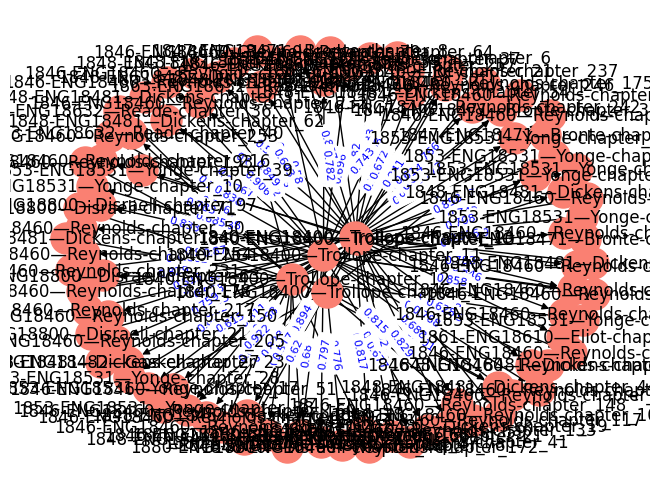

In [128]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

 # Draw nodes with labels
nx.draw(G, width=1, node_size=500, node_color='salmon', with_labels=True)
# Draw edges with arrows and labels
edge_labels = nx.get_edge_attributes(G, 'comp_score')
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=TEXT_FONT_SIZE)


In [129]:
C = CytoscapeWidget()
#C.set_layout(name='cola')
C.set_layout(name='dagre', rankDir='LR', spacingFactor=3)
C.graph.add_graph_from_networkx(G, directed=True)


In [130]:
#this is so we can programmatically edit and choose variables for the graph

def build_style(color_threshold):
    return [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'salmon',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'label': 'data(id)'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': 'black',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'color': 'blue',
                 'label': 'data(comp_score)',
                'width': f"mapData(comp_score, {min_comp_score}, {max_comp_score}, 1, 10)"
                 #'width': '10px',
             }
        },
        {
            "selector": "edge.directed",
            "style": {
                "curve-style": "bezier",
                "target-arrow-shape": "triangle",
                "target-arrow-color": "black",
            }
        }, 
        {
            "selector": f"edge[comp_score>{color_threshold}]",
            "style": {
                "line-color": "red",
            }
        },
    ]
style = build_style(0.92)
pprint(style)
C.set_style(style)

[{'selector': 'node',
  'style': {'background-color': 'salmon',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(id)'}},
 {'selector': 'edge',
  'style': {'color': 'blue',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(comp_score)',
            'line-color': 'black',
            'width': 'mapData(comp_score, 0.438, 0.922, 1, 10)'}},
 {'selector': 'edge.directed',
  'style': {'curve-style': 'bezier',
            'target-arrow-color': 'black',
            'target-arrow-shape': 'triangle'}},
 {'selector': 'edge[comp_score>0.92]', 'style': {'line-color': 'red'}}]


In [131]:
#make slider

caption = widgets.Label(value='The slider value is in its initial position.')

slider = widgets.IntSlider(
    value=90,
    min=90,
    max=100,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def handle_slider_change(change):
    color_threshold = change.new / 100
    caption.value = f"The slider value is: {color_threshold}"
    style = build_style(color_threshold=color_threshold)
    C.set_style(style)
    
slider.observe(handle_slider_change, names='value')
display(caption, slider)

Label(value='The slider value is in its initial position.')

IntSlider(value=90, continuous_update=False, description='Test:', min=90)

In [132]:
C

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'LR', 'spacingFactor': 3}, cytoscape_style=[{'se…

 # MOVE OVER TO CYTOSCAPE APP FOR STRETCHY THINGS

 ## todo

 1. annotate edges in dataset
 2. regenerate all data
 3. deal with SVMs
 4. document and lock sequence alignment version
 5. fully remove and document removal of n-grams
 7. display more easy to see
 8. full dataset
 9. moving to dissertation; initial check against tarah's dataset
 10. do full relevant close re-reading
 11. 

In [133]:
p4c.cytoscape_ping()

In cyrest_get: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.


RequestException: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.

In [ ]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.2',
 'automationAPIVersion': '1.9.0',
 'py4cytoscapeVersion': '1.9.0'}

In [ ]:
p4c.create_network_from_networkx(G)


Applying default style...
Applying preferred layout


1276